[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sotirischatzimiltis/MscThesis/blob/main/DataPreProcessing/MultiClassClassification/nsl_kdd_preprocessing_multiclass_minmaxscaler.ipynb)

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split # Import train_test_split function
import warnings
warnings.filterwarnings("ignore")

# Read Datasets

In [ ]:
train_url="https://gitlab.com/schatz06/smart-grid-metering-ids/-/raw/main/NSLKDD/KDDTrain.txt"
test_url= "https://gitlab.com/schatz06/smart-grid-metering-ids/-/raw/main/NSLKDD/KDDTest.txt"
TRAIN_FILE="KDDTrain.txt"
TEST_FILE="KDDTest.txt"
![ -f "$TRAIN_FILE" ] && echo "$TRAIN_FILE exists" || wget "$train_url"
![ -f "$TEST_FILE" ] && echo "$TEST_FILE exists" || wget "$test_url"

KDDTrain.txt exists
KDDTest.txt exists


In [ ]:
dataset_train = pd.read_csv("KDDTrain.txt", sep=",",header =None)
dataset_train = dataset_train.iloc[:,:-1] # remove difficulty column

In [ ]:
dataset_test = pd.read_csv("KDDTest.txt",sep=",",header=None)
dataset_test = dataset_test.iloc[:,:-1] # remove difficulty column

Sample View of Training and Test datasets

In [ ]:
dataset_train.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
dataset_test.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan


Columns names of Training and Test Datasets

In [ ]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

Shape of Training and Test Datasets

In [ ]:
print("Shape of Training Dataset:", dataset_train.shape)
print("Shape of Testing Dataset:", dataset_test.shape)

Shape of Training Dataset: (125973, 42)
Shape of Testing Dataset: (22544, 42)


Columns Assignment

In [ ]:
dataset_train.columns = col_names # append labels
dataset_test.columns = col_names 

Labels of Training and Test Datasets

In [ ]:
#label distribution of Training set and testing set
print('Label distribution Training set:')
print(dataset_train['label'].value_counts())
print()
print('Label distribution Test set:')
print(dataset_test['label'].value_counts())

Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Label distribution Test set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178


# Data Pre-processing

## Handle categorical features

In [ ]:
# colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in dataset_train.columns:
    if dataset_train[col_name].dtypes == 'object' :
        unique_cat = dataset_train[col_name].nunique()
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

# Test set
print('Test set:')
for col_name in dataset_test.columns:
    if dataset_test[col_name].dtypes == 'object' :
        unique_cat = len(dataset_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories
Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


One-hot-Encoding

In [ ]:
one_hot_encoder = preprocessing.OneHotEncoder() # create one hot encoder

Protocol Type

In [ ]:
# fit one hot encoder
one_hot_encoder.fit(dataset_train['protocol_type'].values.reshape(-1,1))

#train dataset
train_transform = one_hot_encoder.transform(dataset_train['protocol_type'].values.reshape(-1,1)) 
train_transform = train_transform.toarray()
train_df = pd.DataFrame(train_transform, columns = one_hot_encoder.get_feature_names_out())
del dataset_train['protocol_type']
dataset_train = pd.concat([dataset_train,train_df], axis=1)

#test dataset
test_transform = one_hot_encoder.transform(dataset_test['protocol_type'].values.reshape(-1,1)) 
test_transform = test_transform.toarray()
test_df = pd.DataFrame(test_transform , columns = one_hot_encoder.get_feature_names_out())
del dataset_test['protocol_type']
dataset_test = pd.concat([dataset_test,test_df], axis=1)

Service 

In [ ]:
# fit one hot encoder
one_hot_encoder.fit(dataset_train['service'].values.reshape(-1,1))

# train dataset
train_transform = one_hot_encoder.transform(dataset_train['service'].values.reshape(-1,1)) 
train_transform = train_transform.toarray()
train_df = pd.DataFrame(train_transform, columns = one_hot_encoder.get_feature_names_out())
del dataset_train['service']
dataset_train = pd.concat([dataset_train,train_df], axis=1)

# test dataset
test_transform = one_hot_encoder.transform(dataset_test['service'].values.reshape(-1,1)) 
test_transform = test_transform.toarray()
test_df = pd.DataFrame(test_transform , columns = one_hot_encoder.get_feature_names_out())
del dataset_test['service']
dataset_test = pd.concat([dataset_test,test_df], axis=1)

Flag

In [ ]:
# fit one hot encoder
one_hot_encoder.fit(dataset_train['flag'].values.reshape(-1,1))

# train dataset
train_transform = one_hot_encoder.transform(dataset_train['flag'].values.reshape(-1,1)) 
train_transform = train_transform.toarray()
train_df = pd.DataFrame(train_transform, columns = one_hot_encoder.get_feature_names_out())
del dataset_train['flag']
dataset_train = pd.concat([dataset_train,train_df], axis=1)

# test dataset
test_transform = one_hot_encoder.transform(dataset_test['flag'].values.reshape(-1,1)) 
test_transform = test_transform.toarray()
test_df = pd.DataFrame(test_transform , columns = one_hot_encoder.get_feature_names_out())
del dataset_test['flag']
dataset_test = pd.concat([dataset_test,test_df], axis=1)

In [ ]:
print("Shape of Training Dataset:", dataset_train.shape)
print("Shape of Testing Dataset:", dataset_test.shape)

Shape of Training Dataset: (125973, 123)
Shape of Testing Dataset: (22544, 123)


In [ ]:
dataset_train.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,x0_REJ,x0_RSTO,x0_RSTOS0,x0_RSTR,x0_S0,x0_S1,x0_S2,x0_S3,x0_SF,x0_SH
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Multiclass Classification Dataset

Rename every attack label: 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R.
Replace labels column with new labels column

In [ ]:
dataset_train_multiclass = dataset_train.copy()
dataset_train_multiclass = dataset_train_multiclass.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})

In [ ]:
print(dataset_train_multiclass['label'])

0         0
1         0
2         1
3         0
4         0
         ..
125968    1
125969    0
125970    0
125971    1
125972    0
Name: label, Length: 125973, dtype: int64


In [ ]:
dataset_test_multiclass = dataset_test.copy()
dataset_test_multiclass = dataset_test_multiclass.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})

In [ ]:
print(dataset_test_multiclass['label'])

0        1
1        1
2        0
3        2
4        2
        ..
22539    0
22540    0
22541    1
22542    0
22543    2
Name: label, Length: 22544, dtype: int64


## Save various version of multiclass datasets

Scaling

In [ ]:
x_train = dataset_train_multiclass.drop('label',1)
y_train = dataset_train_multiclass.label

x_test = dataset_test_multiclass.drop('label',1)
y_test = dataset_test_multiclass.label

In [ ]:
colNames = list(x_train)
colNames_test = list(x_test)

In [ ]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

Initial Dataset

In [ ]:
x_train = pd.DataFrame(x_train)
x_train.columns= colNames
y_train = pd.DataFrame(y_train)
y_train.columns = ['label']
train_frame = [x_train,y_train]
train_final_binary = pd.concat(train_frame,axis=1)
train_final_binary.to_csv('train_multiclass.csv',index = False)

In [ ]:
x_test = pd.DataFrame(x_test)
x_test.columns= colNames
y_test = pd.DataFrame(y_test)
y_test.columns = ['label']
test_frame = [x_test,y_test]
test_binary = pd.concat(test_frame,axis=1)
test_binary.to_csv('test_multiclass.csv',index = False)

PCA

In [ ]:
from sklearn.decomposition import PCA # import pca

Text(0, 0.5, 'Explained variance (%)')

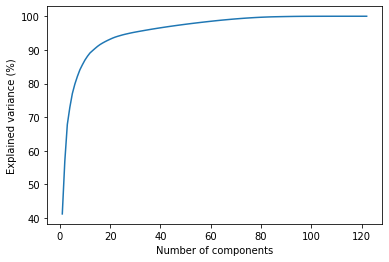

In [ ]:
# plot the variance explanation of the 29 components needed to cover 95% initial data variance 
pca = PCA(None)
pca.fit(x_train)
components = len(pca.explained_variance_ratio_)
plt.plot(range(1,components+1), 
np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

In [ ]:
# Make an instance of the Model
pca = PCA(.95) # 0.95: means we want 95% of data variance

In [ ]:
pca.fit(x_train)

PCA(n_components=0.95)

In [ ]:
print(pca.n_components_)

29


In [ ]:
x_train_pca = pca.transform(x_train)  # perform pca
x_test_pca= pca.transform(x_test)

In [ ]:
#min max scale again
scaler.fit(x_train_pca)
x_train_pca = scaler.transform(x_train_pca)
x_test_pca = scaler.transform(x_test_pca)

In [ ]:
x_train_pca = pd.DataFrame(x_train_pca)
y_train = pd.DataFrame(y_train)
y_train.columns = ['label']
train_frame = [x_train_pca,y_train]
train_final_pca = pd.concat(train_frame,axis=1)
train_final_pca.to_csv('train_pca_multiclass.csv',index = False)

In [ ]:
x_test_pca = pd.DataFrame(x_test_pca)
y_test = pd.DataFrame(y_test)
y_test.columns = ['label']
test_frame = [x_test_pca,y_test]
testall = pd.concat(test_frame,axis=1)
testall.to_csv('test_pca_multiclass.csv',index = False)

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=3,
                                 bootstrap=True, n_jobs=-1,
                                 random_state=0)
rf.fit(x_train.values, y_train.values.ravel())

feature_imp = pd.Series(rf.feature_importances_, 
                        index=x_train.columns).sort_values(ascending=False)

In [ ]:
for i in range(0,len(feature_imp)):
    print(i,end =" ")
    print(feature_imp.index[i],end = ": ")
    print(feature_imp[i])

0 srv_serror_rate: 0.11126826769959161
1 same_srv_rate: 0.1056867361683466
2 diff_srv_rate: 0.09433253808006274
3 x0_SF: 0.07183825381138678
4 dst_host_serror_rate: 0.06491022091568122
5 x0_S0: 0.05958047210968945
6 serror_rate: 0.059422480738052535
7 dst_host_srv_serror_rate: 0.052034572030407275
8 count: 0.04549825205126207
9 logged_in: 0.04381767856714095
10 dst_host_same_srv_rate: 0.03975320465280831
11 dst_host_diff_srv_rate: 0.029668313880087574
12 dst_host_same_src_port_rate: 0.02715454781700185
13 dst_host_srv_count: 0.0193673368988948
14 x0_eco_i: 0.018141590366220803
15 srv_count: 0.016435678881196795
16 x0_private: 0.014312709699423332
17 x0_http: 0.013078907237350732
18 dst_host_srv_diff_host_rate: 0.012863033619748268
19 x0_icmp: 0.01132972725840103
20 rerror_rate: 0.011111016940683376
21 srv_diff_host_rate: 0.010301689480508502
22 dst_host_count: 0.009973892853555792
23 dst_host_rerror_rate: 0.008604923014260336
24 dst_host_srv_rerror_rate: 0.008456597720438363
25 x0_doma

RF0.05

In [ ]:
new_features = [] # list containing the new features names
for i in range(0,len(feature_imp)): # for for the range of all features
    if feature_imp[i] > 0.05: # check if importance is over the threshold
        new_features.append(feature_imp.index[i])
print(new_features)

['srv_serror_rate', 'same_srv_rate', 'diff_srv_rate', 'x0_SF', 'dst_host_serror_rate', 'x0_S0', 'serror_rate', 'dst_host_srv_serror_rate']


In [ ]:
x_train_05 = x_train[new_features] #cast new dataframes
x_test_05 = x_test[new_features]

In [ ]:
x_train_05 = pd.DataFrame(x_train_05)
x_train_05.columns= new_features
y_train = pd.DataFrame(y_train)
y_train.columns = ['label']
train_frame = [x_train_05,y_train]
train_final_rf05 = pd.concat(train_frame,axis=1)
train_final_rf05.to_csv('train_rf05_multiclass.csv',index = False)

In [ ]:
x_test_05 = pd.DataFrame(x_test_05)
x_test_05.columns= new_features
y_test = pd.DataFrame(y_test)
y_test.columns = ['label']
test_frame = [x_test_05,y_test]
test_rf05 = pd.concat(test_frame,axis=1)
test_rf05.to_csv('test_rf05_multiclass.csv',index = False)

RF0.005

In [ ]:
new_features = [] # list containing the new features names
for i in range(0,len(feature_imp)): # for for the range of all features
    if feature_imp[i] > 0.005: # check if importance is over the threshold
        new_features.append(feature_imp.index[i])
print(new_features)

['srv_serror_rate', 'same_srv_rate', 'diff_srv_rate', 'x0_SF', 'dst_host_serror_rate', 'x0_S0', 'serror_rate', 'dst_host_srv_serror_rate', 'count', 'logged_in', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_count', 'x0_eco_i', 'srv_count', 'x0_private', 'x0_http', 'dst_host_srv_diff_host_rate', 'x0_icmp', 'rerror_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'x0_domain_u', 'x0_ecr_i', 'x0_tcp']


In [ ]:
x_train_005 = x_train[new_features] #cast new dataframes
x_test_005 = x_test[new_features]

In [ ]:
x_train_005 = pd.DataFrame(x_train_005)
x_train_005.columns= new_features
y_train = pd.DataFrame(y_train)
y_train.columns = ['label']
train_frame = [x_train_005,y_train]
train_final_rf005 = pd.concat(train_frame,axis=1)
train_final_rf005.to_csv('train_rf005_multiclass.csv',index = False)

In [ ]:
x_test_005 = pd.DataFrame(x_test_005)
x_test_005.columns= new_features
y_test = pd.DataFrame(y_test)
y_test.columns = ['label']
test_frame = [x_test_005,y_test]
test_rf005 = pd.concat(test_frame,axis=1)
test_rf005.to_csv('test_rf005_multiclass.csv',index = False)

ANOVA TESTING

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore');
selector=SelectPercentile(f_classif, percentile=10)
x_train_new = selector.fit_transform(x_train,y_train)
x_train_new.shape

(125973, 13)

In [ ]:
true=selector.get_support()
newcolindex=[i for i, x in enumerate(true) if x]
newcolname=list(colNames[i] for i in newcolindex)
newcolname

['logged_in',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'x0_http',
 'x0_S0',
 'x0_SF']

In [ ]:
x_train_anova = x_train[newcolname] #cast new dataframes
x_test_anova = x_test[newcolname]

In [ ]:
x_train_anova = pd.DataFrame(x_train_anova)
x_train_anova.columns= newcolname
y_train = pd.DataFrame(y_train)
y_train.columns = ['label']
train_frame = [x_train_anova,y_train]
train_final_anova = pd.concat(train_frame,axis=1)
train_final_anova.to_csv('train_anova_multiclass.csv',index = False)

In [ ]:
x_test_anova = pd.DataFrame(x_test_anova)
x_test_anova.columns= newcolname
y_test = pd.DataFrame(y_test)
y_test.columns = ['label']
test_frame = [x_test_anova,y_test]
test_anova = pd.concat(test_frame,axis=1)
test_anova.to_csv('test_anova_multiclass.csv',index = False)

Create 1 dataset for every attack category
**we are doing many binary classifications**

In [ ]:
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]
DoS_df=dataset_train_multiclass[~dataset_train_multiclass['label'].isin(to_drop_DoS)];
Probe_df=dataset_train_multiclass[~dataset_train_multiclass['label'].isin(to_drop_Probe)];
R2L_df=dataset_train_multiclass[~dataset_train_multiclass['label'].isin(to_drop_R2L)];
U2R_df=dataset_train_multiclass[~dataset_train_multiclass['label'].isin(to_drop_U2R)];

#test
DoS_df_test=dataset_test_multiclass[~dataset_test_multiclass['label'].isin(to_drop_DoS)];
Probe_df_test=dataset_test_multiclass[~dataset_test_multiclass['label'].isin(to_drop_Probe)];
R2L_df_test=dataset_test_multiclass[~dataset_test_multiclass['label'].isin(to_drop_R2L)];
U2R_df_test=dataset_test_multiclass[~dataset_test_multiclass['label'].isin(to_drop_U2R)];
print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)
Test:
Dimensions of DoS: (17171, 123)
Dimensions of Probe: (12132, 123)
Dimensions of R2L: (12596, 123)
Dimensions of U2R: (9778, 123)


Split features and labels

In [ ]:
# Split dataframes into X & Y
# assign X as a dataframe of feautures and Y as a series of outcome variables
X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label
X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label
X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label
X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label

# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label
X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label
X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label
X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label

Feature Scaling/Standard Scaling

In [ ]:
colNames = list(X_DoS)
colNames_test = list(X_DoS_test)

In [ ]:
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 
scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe) 
scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L) 
scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 
# test data
X_DoS_test=scaler1.transform(X_DoS_test) 
X_Probe_test=scaler2.transform(X_Probe_test) 
X_R2L_test=scaler3.transform(X_R2L_test) 
X_U2R_test=scaler4.transform(X_U2R_test)

### Feature Selection/Dimensionality Reduction Algorithms